In [210]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

In [211]:
flight_data = pd.read_csv('Clean_Dataset.csv')
flight_data.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [212]:
flight_data.shape

(300153, 12)

Because there 300153 rows, I limited the data to ~ 50,000 rows so the training of the model wouldn't take a very long time on my laptop.

In [213]:
#Randomly sampling 50,000 rows to use as our data. random_state is for reproducibility.
flight_data = flight_data.sample(n = 1000, random_state = 42)

In [214]:
flight_data.describe()

,Unnamed: 0,duration,days_left,price
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,144905.771000,12.169290,25.882000,20020.685000
std,87018.045615,7.172312,13.599302,22496.083452
min,49.000000,1.080000,1.000000,1105.000000
25%,69877.000000,6.670000,14.000000,4823.750000
50%,143671.000000,11.250000,25.000000,7021.000000
75%,218396.750000,16.020000,38.000000,41269.000000
max,300089.000000,36.830000,49.000000,98839.000000


In [215]:
flight_data.isnull().sum()

Unnamed: 0          0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [216]:
flight_data.columns

Index(['Unnamed: 0', 'airline', 'flight', 'source_city', 'departure_time',
       'stops', 'arrival_time', 'destination_city', 'class', 'duration',
       'days_left', 'price'],
      dtype='object')

In [217]:
flight_data['flight'].nunique()

449

In [218]:
flight_data.drop(['Unnamed: 0', 'flight'], axis = 1, inplace = True)

In [219]:
#Splitting categorical and numerical columns for EDA and for preprocessing
numeric = flight_data.select_dtypes([np.number])
categorical = flight_data.drop(['duration', 'days_left', 'price'], axis = 1)

## EDA

In [220]:
#function to draw histograms for each column
def draw_hist(df, columns):
    for i in columns:
        sns.histplot(data = df[i])
        plt.show()

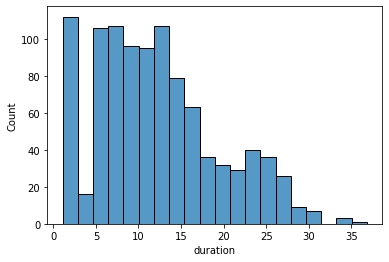

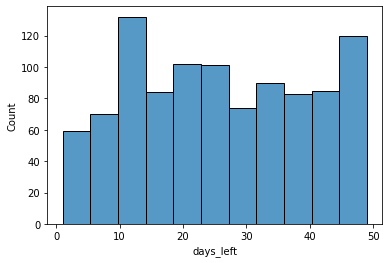

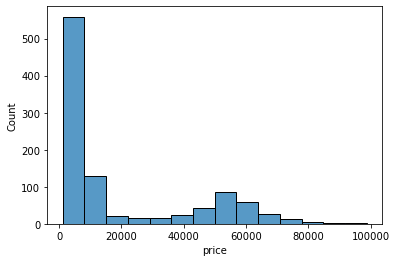

In [221]:
draw_hist(flight_data, numeric)

In [222]:
#Note: why histogram of days_left have gap?

In [223]:
#countplots
def draw_count(df, columns):
    for i in columns:
        sns.countplot(x = df[i])
        plt.show()

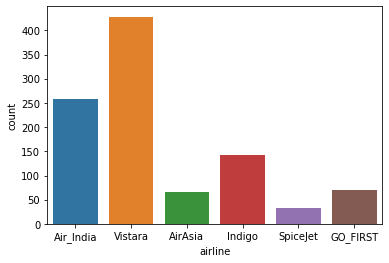

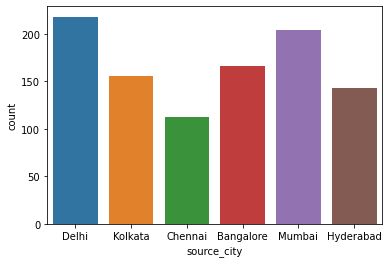

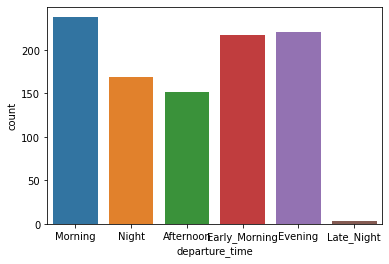

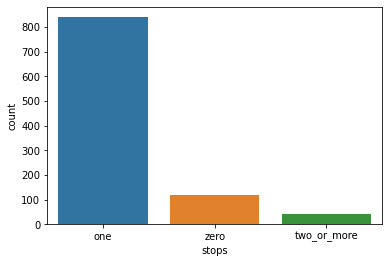

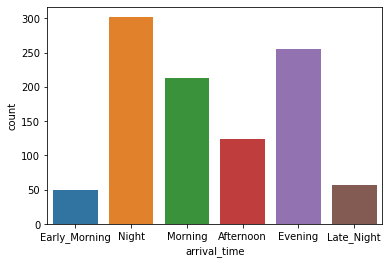

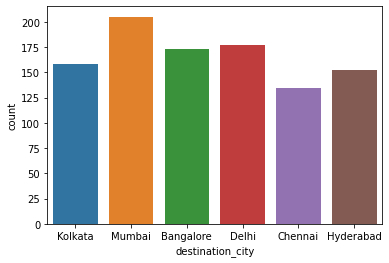

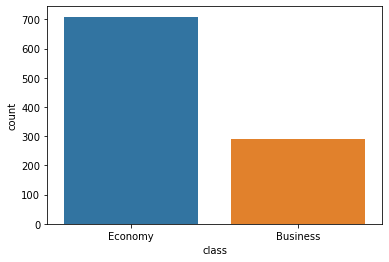

In [224]:
draw_count(flight_data, categorical)

Just by examining the column names, here are some categorical features I wanted to investigate as they related to price

In [225]:
hue_list = ['airline', 'departure_time', 'stops', 'class']

In [226]:
def draw_hue_hist(df, feature_list):
    for i in feature_list:
        sns.histplot(x = df['price'], hue = df[i], bins = 20)
        plt.show()

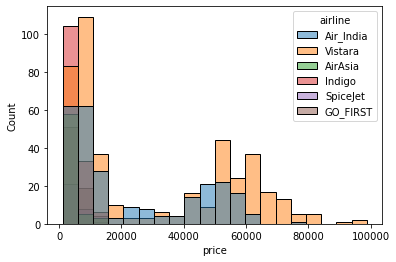

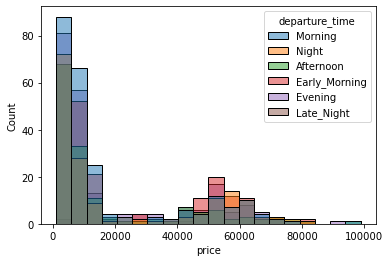

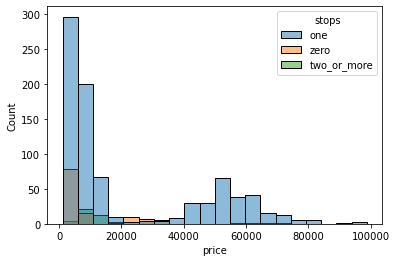

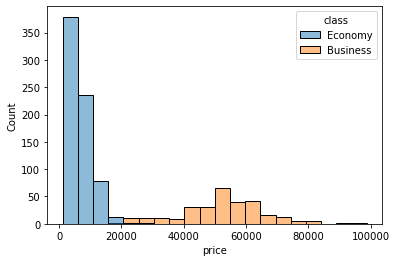

In [227]:
draw_hue_hist(flight_data, hue_list)

airline and departure_time have a lot of unique categories, so it is hard to see the differences in the distributions of those categories. We can try looking at the median price grouped by departure_time and airline separately. 

In [228]:
flight_data.groupby('airline').median()

,duration,days_left,price
airline,,,
AirAsia,8.29,25.0,3090.0
Air_India,15.42,24.0,11785.0
GO_FIRST,8.83,27.0,5102.0
Indigo,6.08,25.0,4515.0
SpiceJet,8.33,23.0,5818.0
Vistara,12.67,25.5,12089.5


In [229]:
flight_data.groupby('departure_time').median()

,duration,days_left,price
departure_time,,,
Afternoon,8.125,26.0,6450.0
Early_Morning,12.080,23.0,8988.0
Evening,14.500,28.0,7135.0
Late_Night,6.080,47.0,4498.0
Morning,10.080,25.0,6573.0
Night,12.750,24.0,6809.0


There are also some numerical features I wanted to explore

In [230]:
numeric_scatter_list = ['duration', 'days_left']

In [231]:
def draw_scatter(df, scatter_list):
    for i in scatter_list:
        sns.scatterplot(x = df[i], y = df['price'])
        plt.show()

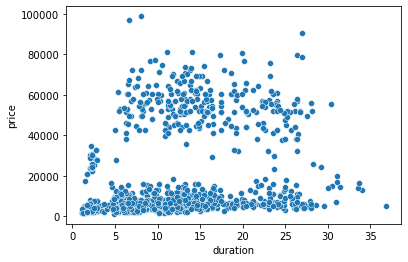

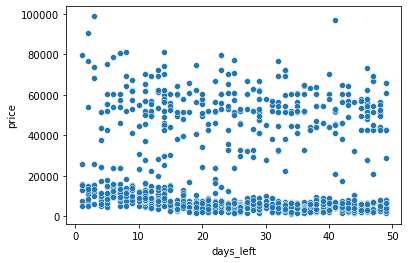

In [232]:
draw_scatter(flight_data, numeric_scatter_list)

In [233]:
#Can't make out much from the graphs

Correlations

In [234]:
def corr_matrix(df):
    fig, ax = plt.subplots(figsize = (10, 10))
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

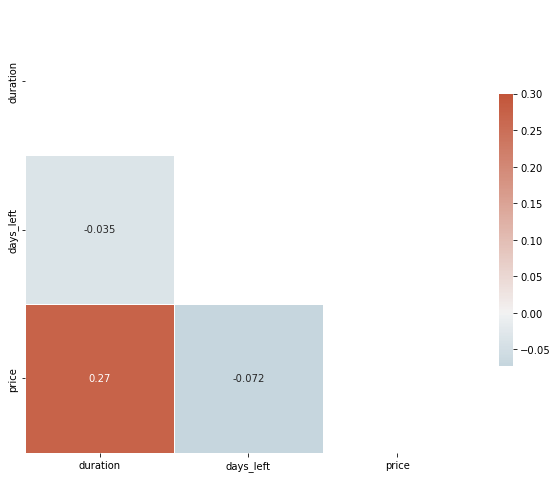

In [235]:
corr_matrix(flight_data)

# Creating Pipeline

## Preprocessing:  
Since there are no null values, we just have to perform the following transformations to our data:  
  
  1. Scale numeric data
  2. One hot encode categorical data

In [236]:
#Separating features and target
X = flight_data.drop('price', axis = 1)
y = flight_data['price']

In [237]:
#Creating OneHotEncoder and StandardScaler objects
ohe = OneHotEncoder(handle_unknown='ignore', sparse = False)
scaler = StandardScaler()

In [238]:
#dropping price (the target) from our numeric columns
numeric.drop('price', axis = 1, inplace = True)

In [239]:
#Creating a column transformer
column_trans = make_column_transformer((ohe, list(categorical.columns)), (scaler, list(numeric.columns)), remainder = 'passthrough')
column_trans.fit_transform(X)

array([[ 0.        ,  1.        ,  0.        , ...,  1.        ,
         1.05746984,  1.03866097],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.32631886,  1.18580093],
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
        -0.23285732,  1.11223095],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         2.20830217,  1.40651087],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
        -0.47697327, -0.8741585 ],
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.24421499,  0.74438105]])

In [240]:
logreg = LogisticRegression(solver = 'lbfgs', max_iter=10000)

In [241]:
pipe = make_pipeline(column_trans, logreg)

In [242]:
cross_val_score(pipe, X, y , cv = 5)

c:\Users\kevoi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


array([0.165, 0.22 , 0.19 , 0.165, 0.205])

In [ ]:
#try model with more data (at least 10000)
#try lasso, elastic net models, svr (maybe)